In [51]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math

## Assumptions

- Velocity covariance $\sigma_{x, y} = 0.50 + \frac{v}{10}$
- Reliable 10 meter depth sensing


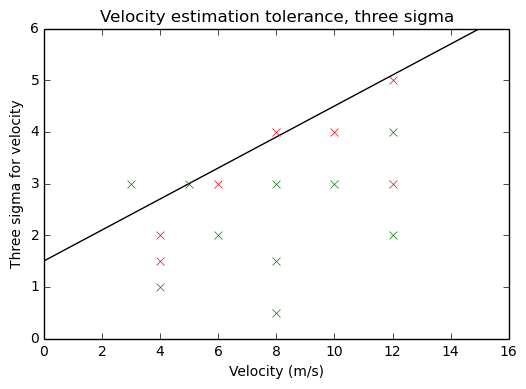

In [52]:
velocities = np.linspace(0,15,1000)
three_sigmas = 3.0*(0.50*np.ones(1000) + np.abs(velocities)/10.0)
plt.plot(velocities,three_sigmas, color='k')
#plt.ylim(0,3)
plt.title('Velocity estimation tolerance, three sigma')
plt.legend(loc="upper left")
plt.xlabel('Velocity (m/s)')
plt.ylabel('Three sigma for velocity')
successful_velocity = [3,5,8,8,8,12,12,10,4,6]
successful_error    = [3,3,0.5,1.5,3,2,4,3,1,2]
plt.plot(successful_velocity,successful_error,'x', color='g')

failure_velocity = [8,12,10,4,4,6,12]
failure_error    = [4,5,4,1.5,2,3,3]
plt.plot(failure_velocity,failure_error,'x', color='r')
plt.show() 

## Limits on Swerving

In [55]:
def max_allowable_obstacle_width(max_accel_allowed, velocity_towards_obstacle, sensor_range=10.0):
    time_until_crash = sensor_range / velocity_towards_obstacle
    j_tf = 0.200 #jerk linear approximation time
    time_until_crash -= j_tf
    max_dodge_width = 1.0/2.0*max_accel_allowed*time_until_crash**2 + \
        3.0/2.0*max_accel_allowed*j_tf*time_until_crash + \
        2.0/3.0*max_accel_allowed*j_tf**2
    one_sigma = 0.01 + time_until_crash*(0.5 + 0.1*velocity_towards_obstacle)
    max_dodge_width -= 3*one_sigma
    return 2*max_dodge_width

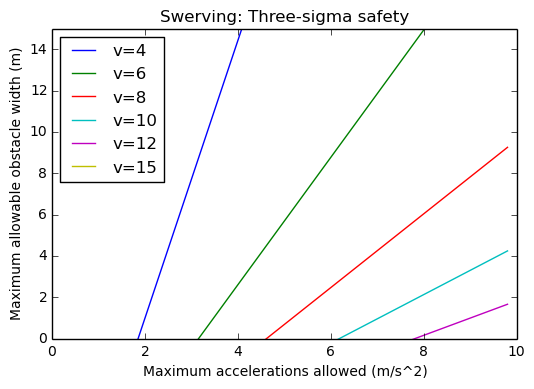

In [58]:
max_roll_allowed = np.linspace(0.0,45.0,100)
accelerations_allowed = max_roll_allowed*0.0
obstacle_widths_allowed = accelerations_allowed*0.0

for index, value in enumerate(max_roll_allowed):
    accelerations_allowed[index] = 9.8 * math.tan(value * np.pi / 180.0) 

    
def plot_for_velocity(velocity):
    for index, value in enumerate(accelerations_allowed):
        obstacle_widths_allowed[index] = max_allowable_obstacle_width(value, velocity)
    plt.plot(accelerations_allowed, obstacle_widths_allowed, label='v='+str(velocity))
    
velocities = [4, 6, 8, 10, 12, 15]

for i in velocities:
    plot_for_velocity(i)
    
plt.ylim(0,15)  
plt.title('Swerving: Three-sigma safety')
plt.legend(loc="upper left")
plt.xlabel('Maximum accelerations allowed (m/s^2)')
plt.ylabel('Maximum allowable obstacle width (m)')
plt.show() 

    

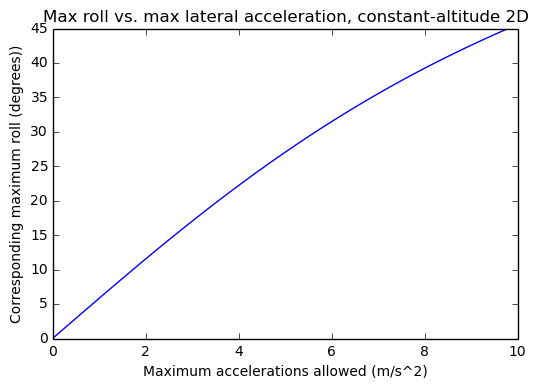

In [59]:
# Correlate maximum lateral accelerations with rolls
plt.plot(accelerations_allowed, max_roll_allowed)
plt.title('Max roll vs. max lateral acceleration, constant-altitude 2D')
plt.xlabel('Maximum accelerations allowed (m/s^2)')
plt.ylabel('Corresponding maximum roll (degrees))')
plt.show() 

## Limits on Stopping

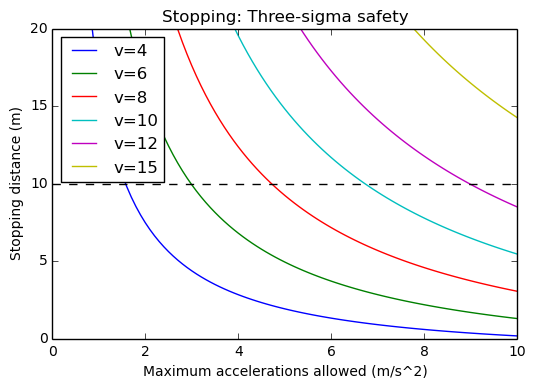

In [61]:
accelerations_allowed = np.linspace(0.1,10,100)
stopping_distances = accelerations_allowed*0.0

def calculate_stopping_distance(max_accel, velocity):
    distance = 1.0/2.0 * velocity**2 / max_accel - 0.3*velocity + 2.0/3.0*max_accel*(0.2)**2 
    time_needed = -0.3 + velocity / max_accel
    one_sigma = 0.01 + time_needed*(0.5 + 0.1*velocity)
    return distance + 3*one_sigma

def plot_for_velocity(velocity):
    for index, value in enumerate(accelerations_allowed):
        stopping_distances[index] = calculate_stopping_distance(value, velocity)
    plt.plot(accelerations_allowed, stopping_distances, label='v='+str(velocity))
    
velocities = [4, 6, 8, 10, 12, 15]

for i in velocities:
    plot_for_velocity(i)
plt.plot([0,10], [10, 10], '--')
plt.ylim(0,20)  
plt.title('Stopping: Three-sigma safety')
plt.legend(loc="upper left")
plt.xlabel('Maximum accelerations allowed (m/s^2)')
plt.ylabel('Stopping distance (m)')
plt.show() 

## Limits on Grazing

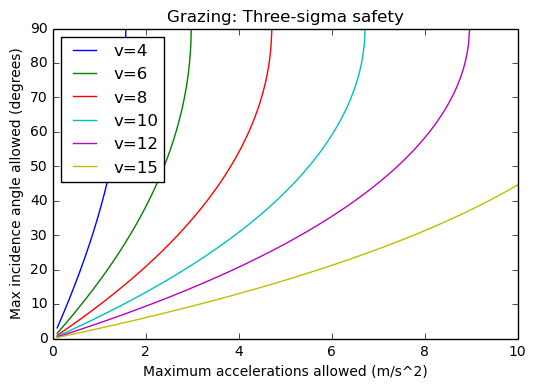

In [62]:
accelerations_allowed = np.linspace(0.1,10,1000)
stopping_distances = accelerations_allowed*0.0
max_incidence_angles = stopping_distances * 0.0


def calculate_max_incidence_angle(stopping_distance):
    sensor_distance = 10.0
    if (stopping_distance < sensor_distance):
        return 90.0
    else: 
        return math.asin(sensor_distance/stopping_distance)*180.0/np.pi
    

def plot_for_velocity(velocity):
    for index, value in enumerate(accelerations_allowed):
        stopping_distances[index] = calculate_stopping_distance(value, velocity)
        max_incidence_angles[index] = calculate_max_incidence_angle(stopping_distances[index])
    plt.plot(accelerations_allowed, max_incidence_angles, label='v='+str(velocity))
    
velocities = [4, 6, 8, 10, 12, 15]

for i in velocities:
    plot_for_velocity(i)
#plt.ylim(0,20)  
plt.title('Grazing: Three-sigma safety')
plt.legend(loc="upper left")
plt.xlabel('Maximum accelerations allowed (m/s^2)')
plt.ylabel('Max incidence angle allowed (degrees)')

plt.show() 


# Realsense degradation

In [10]:
# Avon Park simulation results

### 
# 2D
###
# perfect_realsense
# success: 4, 6, 8, 10
# fail on trees:
# fail on wall: 12

# no_realsense
# success: 4
# fail on trees:
# fail on wall: 6, 8, 10, 12
# fails to see in front during accelerations

# degraded_realsense (entire right vertical half of image is deleted)
# success: 4, 6
# fail on trees: 10, 12
# fail on wall: 8, 10, 12

# degraded_realsense (entire top half of depth image is deleted)
# success: 4, 6
# fail on trees:
# fail on wall: 8, 10, 12

### 
# 3D
###
# perfect_realsense
# success: 4, 6, 8
# fail on trees:
# fail on wall: 10, 12

# degraded_realsense (entire right vertical half of depth image is deleted)
# success: 4, 6
# fail on trees:
# fail on wall: 8, 10, 12

# degraded realsense (entire top half of depth image is deleted)
# success:
# fail on trees: 6, 10, 12
# fail on wall: 4, 8, 10, 12


# 2D vs 3D

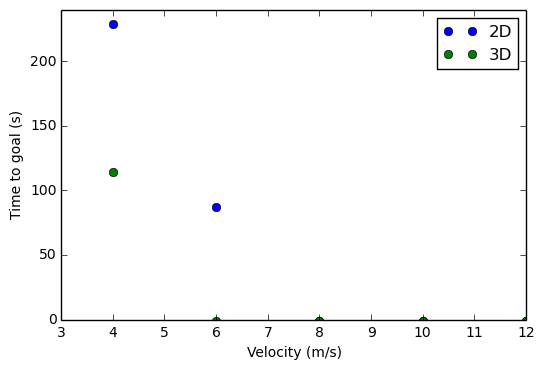

In [38]:
### 3.0 m altitude, at tree leaf altitude
velocities = [4, 6, 8, 10, 12]
two_d_times = [228.77, 86.9, -1.0, -1.0, -1.0] # 8 seconds, crashed because "wall at our height"
plt.plot(velocities, two_d_times, 'o', label='2D')

velocities = [4, 6, 8, 10, 12]
three_d_times = [113.86, -1.0, -1.0, -1.0, -1.0]
plt.plot(velocities, three_d_times, 'o', label='3D')

plt.xlim(3,12)
plt.ylim(0,240)
plt.xlabel('Velocity (m/s)')
plt.ylabel('Time to goal (s)')
plt.legend(loc="upper right")
plt.show()

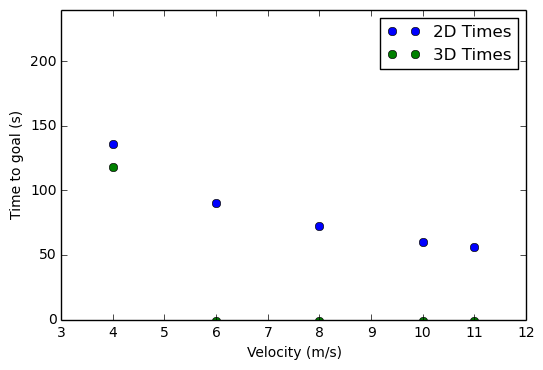

In [45]:
### 1.5 m altitude, at tree trunk altitude
velocities = [4, 6, 8, 10, 11]
two_d_times = [136.23, 90.13, 72.13, 59.72, 56.44]
three_d_times = [117.83, -1.0, -1.0, -1.0, -1.0] # just crashes into wall

plt.plot(velocities, two_d_times, 'o', label='2D Times')
plt.plot(velocities, three_d_times, 'o', label='3D Times')

plt.xlim(3,12)
plt.ylim(0,240)
plt.xlabel('Velocity (m/s)')
plt.ylabel('Time to goal (s)')
plt.legend(loc="upper right")
plt.show()